# Auswertung

In [10]:
#Benötigte Pakete
%matplotlib inline 
import numpy as np
import io
import csv
from decimal import Decimal
import matplotlib.pyplot as plt
from scipy import odr
from scipy.stats import norm
from scipy.integrate import quad
from scipy.optimize import curve_fit
from scipy.signal import argrelextrema
from scipy.stats import chi2
plt.rcParams.update({'font.size': 20})
plt.rcParams["figure.figsize"] = 16, 9

In [2]:
def sig(val1,err1,val2,err2):
    sig = np.abs(val2-val1)**2/np.abs(np.abs(err2)+np.abs(err1))**2
    return sig

def form(val,err): #form function for prints
    a = "{value:4.3f} ± {error:4.3f}".format(value=val,error=err)
    return a

def format_e(n):
    a = '%e' % Decimal(n)
    return a.split('e')[0].rstrip('0').rstrip('.')+'e'+a.split('e')[1]

def form_e(val,err):
    a = format_e(val)
    b = format_e(err)
    return str(a) +' ± '+ str(b)

def fitgüte(x,y,delta_x,delta_y,popt,fit_funktion):    
    chisquare=np.sum((fit_funktion(popt, x)-y)**2/
                     (delta_y**2+((fit_func(popt, x+delta_x)-fit_func(popt, x-delta_x))/2)**2))

    #Freiheitsgrade
    dof=dof = x.size-popt.size
    if dof == 0:
        chisquare_red = 'inf'
        prob = 100
    else:
        chisquare_red = chisquare/dof
        prob = round(1-chi2.cdf(chisquare,dof),3)*100 #Fitwahrscheinlichket

    print('chi_squared= ' + str(chisquare))#format_e(chisquare))
    print('chi_squared_red= ' + str(chisquare_red))#format_e(chisquare_red))
    print('Wahrscheinlichkeit ein größeres oder gleiches Chi-Quadrat zu erhalten: ' +
          str(prob) + ' %')

#Fitfunktion
def fit_func(p, x):
        (s,a) = p 
        return s*x+a

def fit(x,dx,y,dy,c,name,para0,fit_func,plt_range):
    
    from scipy import odr
    model = odr.Model(fit_func)
    
    x = x
    y = y
    delta_x = dx
    delta_y = dy
    
    #Startparameter
    para0 = para0
    
    data = odr.RealData(x, y, sx=delta_x, sy=delta_y)
    odr = odr.ODR(data, model, beta0=para0)
    out = odr.run()

    #1-Sigma
    popt = out.beta
    perr = out.sd_beta

    #Sigma-Umgebung
    nstd = 1 # um n-Sigma-Umgebung im Diagramm zu zeichnen

    popt_top = popt+nstd*perr
    popt_bot = popt-nstd*perr

    #Plot-Umgebung
    x_fit = np.linspace(min(x)-plt_range, max(x)+plt_range, 1000)
    fit = fit_func(popt, x_fit)
    fit_top = fit_func(popt_top, x_fit)
    fit_bot = fit_func(popt_bot, x_fit)

    plt.errorbar(x, y, xerr=delta_x, yerr=delta_y, lw=1, ecolor='k', mec=c, 
                 mfc=c, fmt='.', capsize=2,
                 label='Messdaten '+name)
    plt.plot(x_fit, fit, color=c, lw=1, label='Fit '+name)
    plt.fill_between(x_fit, fit_top, fit_bot, color=c, alpha=.1, 
                     label=str(nstd)+r'$\sigma$'+'-Umgebung')
    print('\nFitgüte '+ name+ ':\n')
    fitgüte(x,y,delta_x,delta_y,popt,fit_func) #[:-3] 
    print('')
    return popt, perr

### Teil 1: Bestimmung der Wellenlänge des Lasers

Die Wellenlänge $\lambda$ berechnet sich aus Gleichung \ref{}:

\begin{align}
    \lambda &= 2\cdot\frac{s}{m}\\
    \Delta\lambda &= \sqrt{\left(2\frac{1}{m}\Delta m \right)^2 + \left(2\frac{s}{m^2}\Delta s \right)^2}
\end{align}

In [3]:
s = np.full(5,3000)*1e-6 #Abstand [um]
ds = np.full(5,2)*1e-6
m=np.array([11258,11269,11323,11269,11272]) #Anzahl Impulse [counts]
dm = np.sqrt(m)

lam=2*s/m #Wellenlänge
lam_sys=np.sqrt((2/m *ds)**2+(2*s/m**2 *dm)**2)

lam_mean=np.mean(lam) #Mittelwertbilung 
lam_mean_sys=(np.sum(lam_sys**2)/len(lam_sys))**0.5 #syst. Fehler
lam_mean_std=np.std(lam)/np.sqrt(len(lam)) #stat. Fehler
dlam_mean = lam_mean_sys + lam_mean_std

lam_lit=532e-9 #Wert aus Anleitung
dlam_lit=1e-9

#Prüfe auf Signifikanz
def Print(n, v1, dv1, v2, dv2, sy, sub, un, form):
    print('\n'+n+'\n')
    print(sy+'     =', form(v1,dv1), un)
    print(sy+'_'+sub+' =', form(v2,dv2), un)
    print('sigma = ', sig(v1,dv1,v2,dv2),'\n')

Print('Wellenlänge des LASERs',
       lam_mean*1e9, dlam_mean*1e9,lam_lit*1e9,dlam_lit*1e9,'lam','lit', ' [nm]',form)


Wellenlänge des LASERs

lam     = 532.002 ± 5.504  [nm]
lam_lit = 532.000 ± 1.000  [nm]
sigma =  9.223495346015113e-08 



Für die Wellenlänge $\lambda$ erhalten wir:

\begin{align}
    \lambda_\text{mes} &= 532.002 \pm 3.754 &\times 10^{-9} \ \text{[m]}\\
    \lambda_\text{theo} &= 532.000 \pm 1.000 &\times 10^{-9} \ \text{[m]}\\
    &\Rightarrow 0.00\sigma
\end{align}

Der Erhaltene Wert deckt sich hervorragend mit den Herstellerangaben aus der Versuchsanleitungen.

### Teil 2: Bestimmung des Brechungsindex von Luft

Für den Brechungsindex von Luft gilt mit Gleichung \ref{}:

\begin{align}
    \frac{n_0-1}{n(p)-1} &= \frac{p_0 T}{p T_0} & \text{aus \ref{} folgt}\\
    (n_0 - 1) &= (n - 1) \frac{p_0 T}{p T_0} = \frac{\lambda}{2a}\frac{\Delta m}{p}\frac{p_0 T}{T_0}\\
    n_{0}&=1+\frac{\lambda}{2 a} \frac{\Delta m}{p} \frac{p_{0} T}{T_{0}}=1+S \frac{\lambda}{2 a} \frac{p_{0} T}{T_{0}}\\
\Delta n_{0}&=\frac{\lambda S p_{0} T}{2 a T_{0}} \sqrt{\left(\frac{\Delta \lambda}{\lambda}\right)^{2}+\left(\frac{\Delta S}{S}\right)^{2}+\left(\frac{\Delta T}{T}\right)^{2}+\left(\frac{\Delta a}{a}\right)^{2}}
\end{align}


Fitgüte :

chi_squared= 0.14103291669281293
chi_squared_red= 0.017629114586601616
Wahrscheinlichkeit ein größeres oder gleiches Chi-Quadrat zu erhalten: 100.0 %



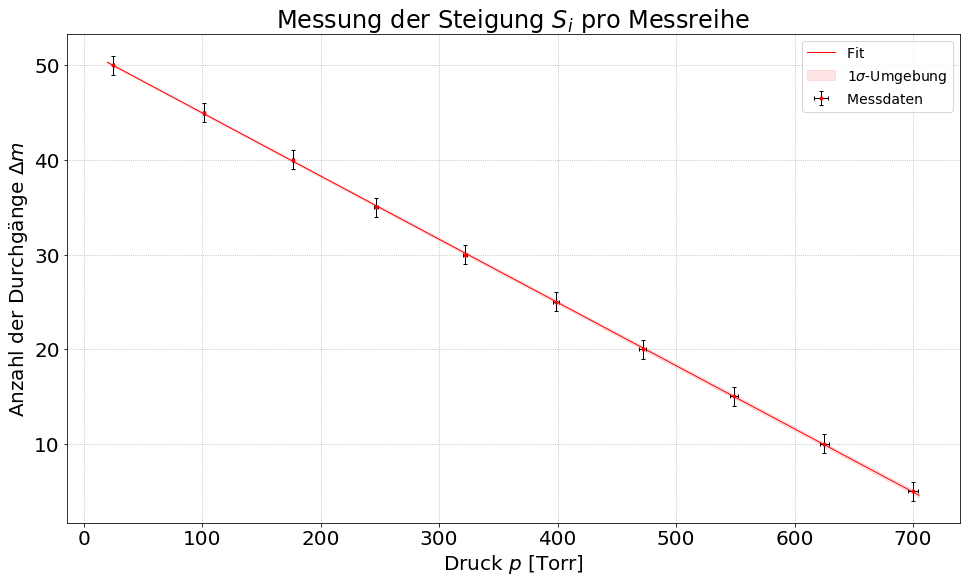


Brechungsindex von Luft

n0     = 9.997064e-01 ± 6.195096e-05 
n0_lit = 1.00028e+00 ± 0e+00 
sigma =  85.72875568839329 



In [5]:
T0=273.15
p0=760 #in Torr, entspricht 101325 Pa
T=23.8+273.15 #Umrechnung in Kelvin
T_err=0.2
a=50e-3 #Innenmaß Küvette
a_err=0.05e-3

def fit_func(p, x):
        (s,a) = p 
        return s*x+a

del_m=np.array([5,10,15,20,25,30,35,40,45,50])
ddel_m=np.full(del_m.size,1)

p1=np.array([700,615,542,465,390,315,240,180,105,25])
dp1=0.006*p1

p2=np.array([700,630,550,475,400,325,250,175,100,25])
dp2=0.006*p2

p3=np.array([700,630,555,475,405,325,250,175,100,25])
dp3=0.006*p3

p = np.mean(np.array([p1,p2,p3]), axis=0)
dp = np.mean(np.array([dp1,dp2,dp3]), axis=0) + np.std(np.array([dp1,dp2,dp3]), axis=0)

popt, perr = fit(p,dp,del_m,ddel_m,
                 'r','',[1,1],fit_func,5.)

plt.title('Messung der Steigung $S_i$ pro Messreihe')
plt.grid(ls=':')
plt.xlabel('Druck $p$ [Torr]')
plt.ylabel('Anzahl der Durchgänge $\\Delta m$')
plt.legend(loc='best',fontsize=14)
plt.show()

#Berechung von n0 aus der Steigung

n0_lit=1.00028 
n0=lam_lit*p0*T/(2*a*T0)*popt[0]+1
dn0=(n0-1)*np.sqrt((dlam_lit/lam_lit)**2
                     +(a_err/a)**2+(T_err/T)**2
                     +(perr[0]**0.5/popt[0])**2)

Print('Brechungsindex von Luft',n0,np.abs(dn0),n0_lit,0,'n0','lit','',form_e)

Wir erhalten für den Brechungsindex von trockener Luft bei Normatmosphäre:

\begin{align}
    n_0 &= 0.99971 \pm 0.00006\\
    n_0^\text{lit} &= 1.00028\\
    &\Rightarrow 83.75\sigma
\end{align}

Der Wert weicht somit **signifikant** vom Literaturwert ab. Darauf soll in der Diskussion genauer eingegangen werden.

### Teil 3: Messung der Kohärenzlänge einer Leuchtdiode

Wir analysieren die Daten aus dem Oszilloskop und Fitten eine Gaussfunktion an diese.
Die Kohährenzlänge entspricht genau der Halbwertsbreite $\text{FWHM}$ der Gaussfunktion nach:

\begin{align}
    \text{FWHM} = 2\sqrt{2\ln{2}} \cdot \sigma \approx 2.355 \sigma
\end{align}

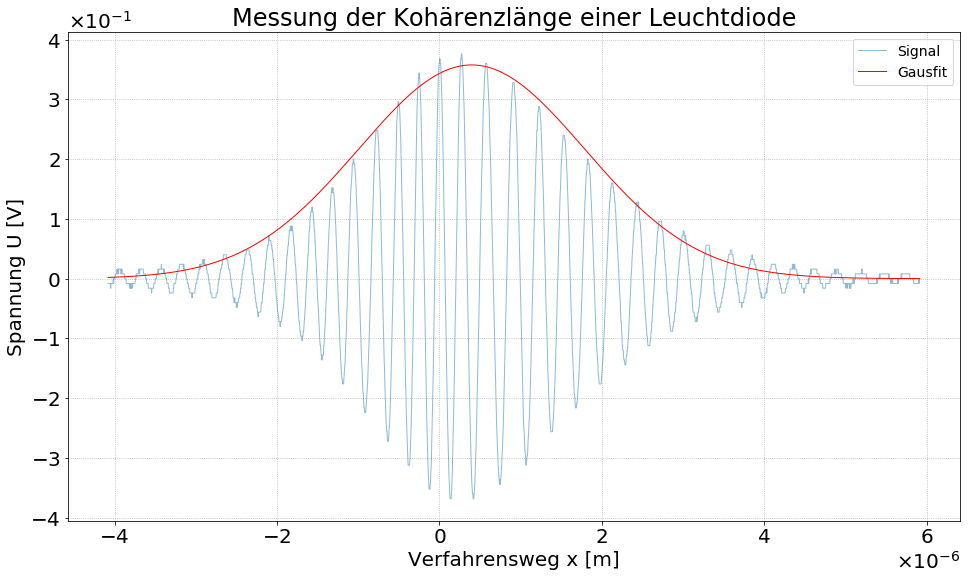


Anzahl der Messungen =  2500

Normalverteilung:

mu =  3.973149e-07  [m]
sigma =  1.392349e-06  [m]

Kohärenzlänge einer Grünen LED:

l_korr =  3.278981e-06  [m]


In [35]:
from scipy.signal import hilbert

v_Verfahren = 0.1 *1e-3 # Verfahrensgeschsindigkeit [m / s]

def gaussian(x, y, mu, sig):
    return norm.pdf(x, mu, sig)*y

#Messwerte aus Datei 2: V über t
t = np.array([])
V = np.array([])
with open('data/Messung Kohährenz.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        t = np.append(t,float(row[3]))
        V = np.append(V,float(row[4]))

x = t*v_Verfahren

analytic_signal = hilbert(V)
amplitude_envelope = np.abs(analytic_signal)

popt, pcov = curve_fit(gaussian, t, amplitude_envelope)

mu = popt[1]*v_Verfahren
sigma = popt[2]*v_Verfahren

#Plot
plt.ticklabel_format(axis='both', style='sci', scilimits=(0,3), useMathText=True)
plt.plot(x, V, lw=1, color='C0', marker='', alpha=.50, label='Signal')
plt.plot(x,gaussian(t,*popt),  lw=1, color='r',
         label='Gausfit')
plt.title('Messung der Kohärenzlänge einer Leuchtdiode')
plt.ylabel('Spannung U [V]')
plt.xlabel('Verfahrensweg x [m]')
plt.grid(ls=':')
plt.legend(loc='best',fontsize=14)
plt.show()

#Auswertung
counts = t.size

#Ausgabe
print('\nAnzahl der Messungen = ', counts)
print('\nNormalverteilung:\n')
print('mu = ',format_e(mu), ' [m]')
print('sigma = ',format_e(sigma), ' [m]')

print('\nKohärenzlänge einer Grünen LED:\n')
print('l_korr = ', format_e(sigma*2.355), ' [m]')

Somit folgt für die Kohärenzlänge:
\begin{align}
    l_\text{korr} = 3.280 \times 10^{-6} \ \text{[m]}
\end{align}